**Thực hiện:** Huỳnh Thanh Tuấn

**Mã số sinh viên:** 20110120

# **1. Setup on Colab**

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
import locale
locale.getpreferredencoding = lambda: "UTF-8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15676, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 15676 (delta 176), reused 287 (delta 95), pack-reused 15277
Receiving objects: 100% (15676/15676), 6.51 MiB | 14.08 MiB/s, done.
Resolving deltas: 100% (11288/11288), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 687.9 kB/s eta 0:

**Check setup**:

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


# **2. Connect with Drive on colab**

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Di chuyển đến thư mục chứa dataset**
```
  Training/Final
  └── dataset
      ├── test
      ├── train
      ├── valid
      ├── README.dataset.txt
      └── README.roboflow.txt
```



In [4]:
%cd /content/drive/MyDrive/DeepLearning/Training/Final

/content/drive/MyDrive/DeepLearning/Training/Final


# **3. Building Model with model zoo: R50-FPN (faster_rcnn_R_50_FPN_3x.yaml)**

In [5]:
# Thêm thư viện
import os

import cv2
import matplotlib.pyplot as plt
import torch

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.engine.hooks import BestCheckpointer
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, DatasetCatalog, MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer


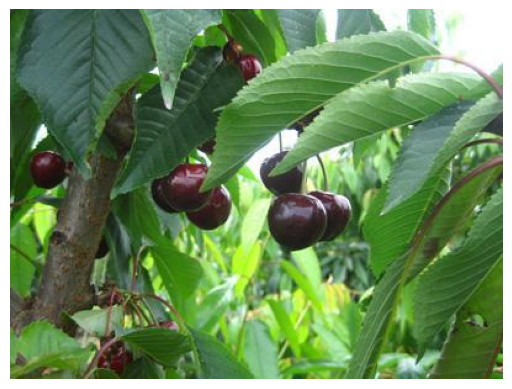

In [6]:
# NOTE (OPTIONAL)
img = cv2.imread("./dataset/test/AnhDao-106-_jpg.rf.bceaa204d8ae714a07028dd4e8dcabb8.jpg")
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_show)
plt.axis("off")
plt.show()

In [7]:
# NOTE (OPTIONAL)
config = get_cfg()
config.MODEL.DEVICE = "cpu"
config.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
)
config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Đặt ngưỡng điểm số nhận diện
config.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)
predictor_sample = DefaultPredictor(config)
outputs = predictor_sample(img)["instances"]
print(outputs.pred_classes)
print(outputs.pred_boxes)

model_final_280758.pkl: 167MB [00:00, 172MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([47, 47, 47])
Boxes(tensor([[ 15.6993, 115.0583,  45.7737, 145.9180],
        [140.6458, 140.7969, 179.5664, 180.1944],
        [118.6469, 124.2567, 181.0311, 180.0805]]))


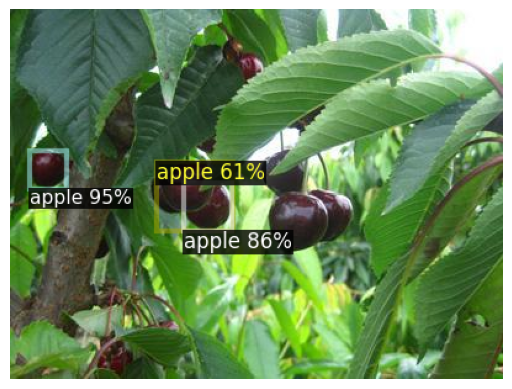

In [16]:
# NOTE (OPTIONAL)
v = Visualizer(
    img[:, :, ::-1],  # chuyển từ BGR (opencv) sang RGB
    MetadataCatalog.get(config.DATASETS.TRAIN[0]),
    font_size_scale=1.2
)
out = v.draw_instance_predictions(outputs)
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

In [15]:
# Bước 1: Chuẩn bị dữ liệu
class_names = [
    "Trai-Cay",
    "Anh-Dao",
    "Bo",
    "Buoi",
    "Cam-Sanh",
    "Cam-Vang",
    "Chanh",
    "Coc",
    "Dau",
    "Du-Du",
    "Dua-Hau",
    "Dua-Luoi",
    "Hong",
    "Khe",
    "Kiwi",
    "Le",
    "Mang-Cau",
    "Mit",
    "Tao",
    "Viet-Quat",
    "Xoai"
]
path_train = "./dataset/train"
path_valid = "./dataset/valid"
path_test = "./dataset/test"
# Đăng ký tập dữ liệu Train, Valid và Test
register_coco_instances("fruit_train", {}, path_train + "/_annotations.coco.json", path_train)
register_coco_instances("fruit_valid", {}, path_valid + "/_annotations.coco.json", path_valid)
register_coco_instances("fruit_test", {}, path_test + "/_annotations.coco.json", path_test)

In [17]:
# Bước 2: Xây dựng model transfer learning với model zoo COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
device = "cuda" if torch.cuda.is_available() else "cpu"

config = get_cfg()
config.MODEL.DEVICE = device
config.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
) # -> trả về đường dẫn tệp cấu hình của model zoo trên máy
config.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
) # -> trả về đường dẫn url của tệp trọng sộ (*.pkl) của model zoo

config.DATASETS.TRAIN = ("fruit_train",)
config.DATASETS.TEST = ("fruit_valid",)

config.DATALOADER.NUM_WORKERS = 2 # Số luồng(threads) tải dữ liệu
config.SOLVER.IMS_PER_BATCH = 6 # Batch size

# NOTE giá trị mặc định của config: https://detectron2.readthedocs.io/en/latest/modules/config.html
# config.OUTPUT_DIR=output
# config.SOLVER.BASE_LR_END=0.0
# config.SOLVER.WARMUP_FACTOR=1.0 / 1000
# config.MODEL.BACKBONE.FREEZE_AT=2 (đóng băng 2 stage đầu của mạng ResNet-50)

n_epochs = 18 # số lượng epoch

iter_per_epoch = int(len(DatasetCatalog.get("fruit_train"))/ config.SOLVER.IMS_PER_BATCH)
max_iters = iter_per_epoch * n_epochs

config.SOLVER.MAX_ITER = max_iters # Số lượng vòng lặp tối đa khi training

config.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
config.SOLVER.BASE_LR = 0.01 # Đặt tốc độ học tối đa
config.SOLVER.WARMUP_ITERS = int(0.2*n_epochs*iter_per_epoch) # Đặt số lượng lần lặp cho giai đoạn tăng lr

config.TEST.EVAL_PERIOD = iter_per_epoch # Thực hiện đánh giá (Test) sau mỗi epoch

config.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # Số lượng vùng quan tâm (ROIS) được lấy tối đa từ mỗi hình ảnh
config.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names) # Số lượng lớp cần phân loại

os.makedirs(config.OUTPUT_DIR, exist_ok=True) # Tạo thư mục ouput (giá trị của config.OUTPUT_DIR)
os.makedirs(config.OUTPUT_DIR + "/inference", exist_ok=True) # Tạo thư mục inference chứa kết quả evaluator khi training

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [18]:
# Bước 3: Training model
class MyTrainer(DefaultTrainer):
  #Override
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
      output_folder = config.OUTPUT_DIR + "/inference"
    return COCOEvaluator(dataset_name, ["bbox"], False, output_dir=output_folder)
  #Override
  def build_hooks(self):
    checkpointer = DetectionCheckpointer(self.model, save_dir=config.OUTPUT_DIR) # Tạo đối tượng checkpointer để lưu model_best
    hooks = super().build_hooks()
    best_checkpointer = BestCheckpointer(
            eval_period=iter_per_epoch,
            checkpointer=checkpointer,
            val_metric="bbox/AP",
        )
    hooks.append(best_checkpointer)
    return hooks

trainer = MyTrainer(config)
trainer.resume_or_load(resume=False) # Không sử dụng lại kết quả training trước

[05/09 12:13:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [ ]:
# Chạy training
trainer.train()

In [20]:
# Bước 4: Chạy model trên ảnh test
# Tải model
cfg = get_cfg()
cfg.MODEL.DEVICE = device
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
)
cfg.MODEL.WEIGHTS = os.path.join(
    cfg.OUTPUT_DIR, "model_best.pth"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Đặt ngưỡng điểm số nhận diện
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names)
# Tạo predictor với cấu hình cfg
predictor = DefaultPredictor(cfg)
# Sử dụng opencv đọc ảnh sample
image_sample = "./dataset/test/AnhDao-106-_jpg.rf.bceaa204d8ae714a07028dd4e8dcabb8.jpg"
img =  cv2.imread(image_sample)
outputs = predictor(img)["instances"].to("cpu") # chuyển kết quả dự đoán từ gpu sang cpu nếu đang chạy trên device cuda
print(outputs.pred_classes)
print(outputs.pred_boxes)

[05/09 15:13:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_best.pth ...
tensor([1, 1, 1, 1, 1])
Boxes(tensor([[113.5440, 123.6209, 166.3164, 166.9776],
        [ 15.0590, 114.0025,  46.8167, 146.5021],
        [209.1391, 148.3820, 257.5534, 196.6155],
        [231.0938, 147.3479, 274.5884, 190.5373],
        [135.9668, 134.5654, 180.8225, 178.5936]]))


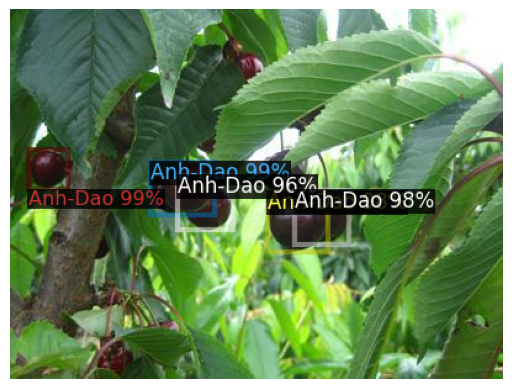

In [21]:
# Sử dụng Visualizer vẽ kết quả lên ảnh
fruit_metadata = {"thing_classes":class_names}
v = Visualizer(
        img[:, :, ::-1],
        metadata=fruit_metadata,
        font_size_scale=1.2
)
out = v.draw_instance_predictions(outputs)
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

In [22]:
# Bước 5: Đánh giá model
evaluator = COCOEvaluator("fruit_test", output_dir=cfg.OUTPUT_DIR) # Tạo đối tượng đánh giá
test_loader = build_detection_test_loader(cfg, "fruit_test") # Tạo đối tượng tải dữ liệu test
print(
    inference_on_dataset(predictor.model, test_loader, evaluator)
)  # In ra kết quả chạy model trên test_loader(tập dữ liệu test) và đánh giá kết quả bằng evaluator

[05/09 15:14:05 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/09 15:14:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/09 15:14:06 d2.data.datasets.coco]: Loaded 239 images in COCO format from ./dataset/test/_annotations.coco.json
[05/09 15:14:06 d2.data.build]: Distribution of instances among all 21 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   fruits   | 0            |  Anh-Dao   | 263          |     Bo     | 55           |
|    Buoi    | 14           |  Cam-Sanh  | 20           |  Cam-Vang  | 40           |
|   Chanh    | 50           |    Coc     | 37           |    Dau     | 52           |
|   Du-Du    | 111          |  Dua-Hau   | 50           |  Dua-Luoi  | 32           |
|    Hong    | 63           |    K

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/09 15:14:08 d2.evaluation.evaluator]: Inference done 11/239. Dataloading: 0.0017 s/iter. Inference: 0.1207 s/iter. Eval: 0.0003 s/iter. Total: 0.1228 s/iter. ETA=0:00:27
[05/09 15:14:40 d2.evaluation.evaluator]: Inference done 44/239. Dataloading: 0.7196 s/iter. Inference: 0.1140 s/iter. Eval: 0.0003 s/iter. Total: 0.8340 s/iter. ETA=0:02:42
[05/09 15:14:45 d2.evaluation.evaluator]: Inference done 85/239. Dataloading: 0.3526 s/iter. Inference: 0.1173 s/iter. Eval: 0.0003 s/iter. Total: 0.4704 s/iter. ETA=0:01:12
[05/09 15:14:50 d2.evaluation.evaluator]: Inference done 131/239. Dataloading: 0.2247 s/iter. Inference: 0.1140 s/iter. Eval: 0.0003 s/iter. Total: 0.3391 s/iter. ETA=0:00:36
[05/09 15:14:55 d2.evaluation.evaluator]: Inference done 169/239. Dataloading: 0.1750 s/iter. Inference: 0.1162 s/iter. Eval: 0.0003 s/iter. Total: 0.2916 s/iter. ETA=0:00:20
[05/09 15:15:01 d2.evaluation.evaluator]: Inference done 198/239. Dataloading: 0.1553 s/iter. Inference: 0.1193 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/09 15:15:11 d2.evaluation.evaluator]: Total inference time: 0:01:03.011802 (0.269281 s / iter per device, on 1 devices)
[05/09 15:15:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:27 (0.117332 s / iter per device, on 1 devices)
[05/09 15:15:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/09 15:15:11 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[05/09 15:15:11 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.84s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.705
 Average